In [7]:
!pip list

Package                Version
---------------------- ---------
anyio                  3.6.2
argon2-cffi            21.3.0
argon2-cffi-bindings   21.2.0
attrs                  22.1.0
Babel                  2.11.0
backcall               0.2.0
beautifulsoup4         4.11.1
bleach                 5.0.1
brotlipy               0.7.0
cbor                   1.0.0
certifi                2022.6.15
cffi                   1.15.0
chardet                4.0.0
charset-normalizer     2.0.4
chest                  0.2.3
colorama               0.4.4
conda                  4.13.0
conda-build            3.21.9
conda-content-trust    0+unknown
conda-package-handling 1.8.1
cryptography           37.0.1
cwl-eval               1.0.12
cycler                 0.11.0
debugpy                1.6.3
decorator              5.1.1
defusedxml             0.7.1
Deprecated             1.2.13
dill                   0.3.6
dnspython              2.2.1
entrypoints            0.4
fastjsonschema         2.16.2
filelock          

In [9]:
!pip install matplotlib opencv-python

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path

Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [9]:
"""def brute_force_surf_matching(image1, image2):
    # Initiate SURF detector
    surf = cv.SURF_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

    # find the keypoints and descriptors with SURF
    kp1, des1 = surf.detectAndCompute(image1_gray, None)
    kp2, des2 = surf.detectAndCompute(image2_gray, None)
    
    if isinstance(kp1, int) or isinstance(kp2, int):
        return [], 0
    elif len(kp1) == 0 or len(kp2) == 0:
        return [], 0

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return img3, len(good)"""

def brute_force_orb_matching(image1, image2):
    # Initiate ORB detector
    orb = cv.ORB_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(image1_gray, None)
    kp2, des2 = orb.detectAndCompute(image2_gray, None)
    
    if isinstance(kp1, int) or isinstance(kp2, int):
        return [], 0
    elif len(kp1) == 0 or len(kp2) == 0:
        return [], 0

    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return img3, len(good)

def brute_force_orb_homography_matching(image1, image2):
    MIN_MATCH_COUNT = 4

    ## Create ORB object and BF object(using HAMMING)
    orb = cv.ORB_create()

    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(image1_gray, None)
    kp2, des2 = orb.detectAndCompute(image2_gray, None)

    # BFMatcher with default params
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    if len(good)>MIN_MATCH_COUNT:
        ## extract the matched keypoints
        src_pts  = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts  = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

        ## find homography matrix and do perspective transform
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        h,w = image1.shape[:2]
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
    
     # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, None,
                             flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return img3, len(good)

# not working with ORB
def flann_index_kdtree_matcher(image1, image2):
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1_gray, None)
    kp2, des2 = sift.detectAndCompute(image2_gray, None)
            
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        
        h,w, _ = image1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        image2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)
    
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
    # img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, **draw_params)
    
    # plt.imshow(img3, ), plt.show()
    
    return img3, len(good)

In [3]:
%%time
import glob

# image_paths = glob.glob('dataset22/images/I0[0-9]/*/image.webp')
image_paths = glob.glob('dataset22/images/I0*/*/image.webp')
# image_paths = glob.glob('dataset22/images/*/*/image.webp')

CPU times: user 442 ms, sys: 333 ms, total: 775 ms
Wall time: 3.83 s


In [5]:
len(image_paths)

23841

In [6]:
(len(image_paths) // 10) * 2

4768

In [4]:
%%time
less_image_paths = image_paths[:(len(image_paths) // 10) * 1]
# images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in less_image_paths]
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]

CPU times: user 29.5 s, sys: 11.4 s, total: 40.9 s
Wall time: 38.8 s


In [37]:
img1 = images[0]
img2 = images[1]
img3 = images[2]
# Displaying the image
# cv.imshow('image', img)
    
# pair1_img, pair1_match_len = flann_index_kdtree_matcher(img1, img2)
pair1_img, pair1_match_len = brute_force_orb_homography_matching(img1, img2)

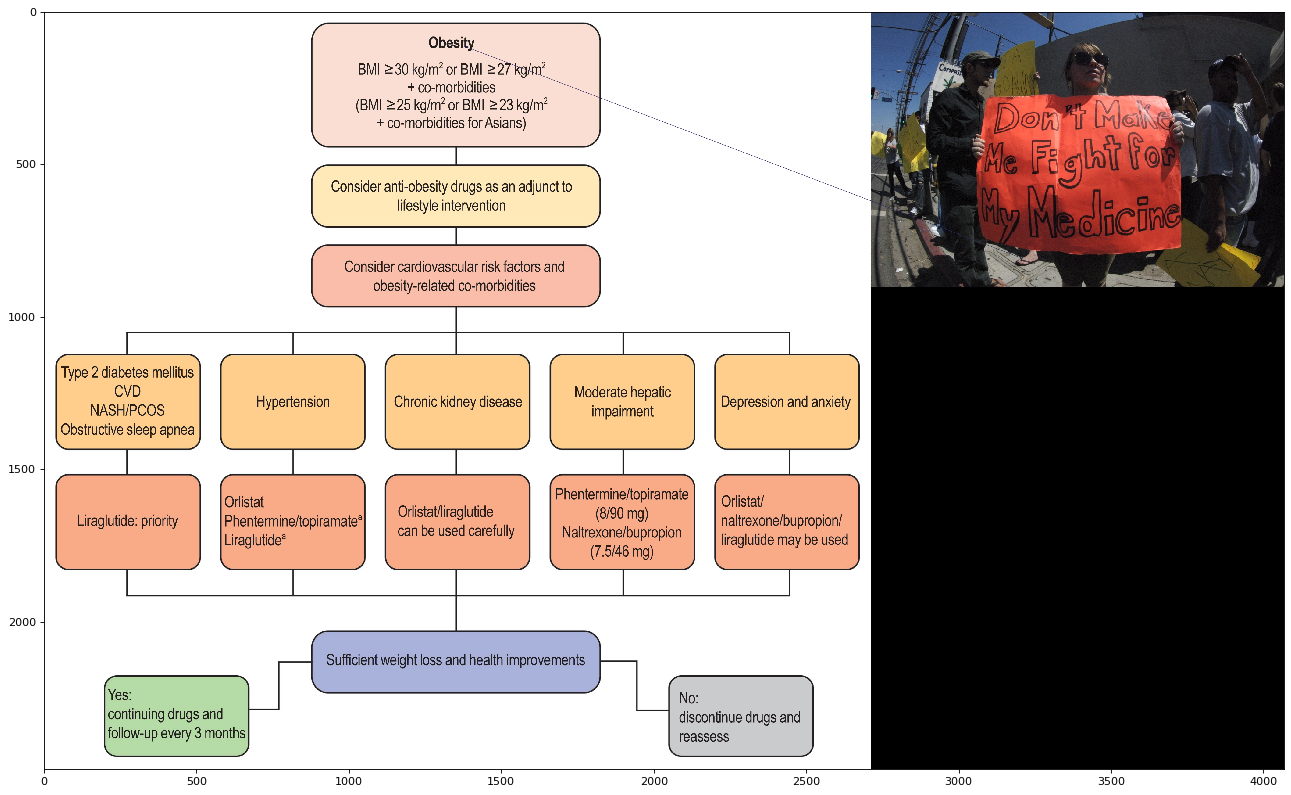

In [38]:
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111)

ax.imshow(pair1_img, interpolation='nearest')

plt.show()

In [8]:
img1 = cv.UMat(images[0])
img2 = cv.UMat(images[1])

%time pair1_img, pair1_good_matches = brute_force_sift_matching(img1, img2)

CPU times: user 6.54 s, sys: 1.4 s, total: 7.94 s
Wall time: 2.35 s


In [ ]:
pair2_img, pair2_good_matches = brute_force_sift_matching_cuda(img1, img3)
# cv.imshow('image', pair2_img)

In [11]:
%%time
topic_img = cv.imread("image_results/topic_generated.png")
# topic_img = cv.UMat(cv.imread("image_results/topic_generated.png"))
best_match_img = []
highest_match_count = 0
highest_img_num = 0
img_num = 0

for image in images:
    # umat_image = cv.UMat(image)
    
    print(img_num)
    img, good_matches = brute_force_orb_matching(topic_img, image)
    # img, good_matches = brute_force_orb_homography_matching(topic_img, image)
    # img, good_matches = flann_index_kdtree_matcher(topic_img, image)
    # img, good_matches = brute_force_orb_matching(topic_img, umat_image)
    
    """print(type(good_matches))
    if type(good_matches) == int:
        print("int:" + str(good_matches))
    else:
        print("Matches: " + str(len(good_matches)))"""
        
    print("Matches: " + str(good_matches))
    print("----")
    
    if highest_match_count < good_matches:
        best_match_img = img
        highest_img_num = img_num
        highest_match_count = good_matches
    
    img_num += 1

0
Matches: 1
----
1
Matches: 5
----
2
Matches: 0
----
3
Matches: 0
----
4
Matches: 5
----
5
Matches: 4
----
6
Matches: 1
----
7
Matches: 2
----
8
Matches: 2
----
9
Matches: 0
----
10
Matches: 5
----
11
Matches: 5
----
12
Matches: 1
----
13
Matches: 4
----
14
Matches: 3
----
15
Matches: 1
----
16
Matches: 0
----
17
Matches: 0
----
18
Matches: 2
----
19
Matches: 2
----
20
Matches: 1
----
21
Matches: 1
----
22
Matches: 0
----
23
Matches: 3
----
24
Matches: 3
----
25
Matches: 1
----
26
Matches: 0
----
27
Matches: 3
----
28
Matches: 1
----
29
Matches: 1
----
30
Matches: 4
----
31
Matches: 3
----
32
Matches: 1
----
33
Matches: 0
----
34
Matches: 1
----
35
Matches: 2
----
36
Matches: 0
----
37
Matches: 2
----
38
Matches: 0
----
39
Matches: 3
----
40
Matches: 0
----
41
Matches: 2
----
42
Matches: 0
----
43
Matches: 1
----
44
Matches: 1
----
45
Matches: 2
----
46
Matches: 1
----
47
Matches: 1
----
48
Matches: 3
----
49
Matches: 3
----
50
Matches: 0
----
51
Matches: 1
----
52
Matches: 3
----
53


In [ ]:
"""
UMAT:   CPU times: user 57.3 s, sys: 24.5 s, total: 1min 21s
        Wall time: 26.2 s

Normal: CPU times: user 55.1 s, sys: 24.7 s, total: 1min 19s
        Wall time: 25.4 s

"""

In [12]:
print(highest_match_count)
print(img_num)

8
1471


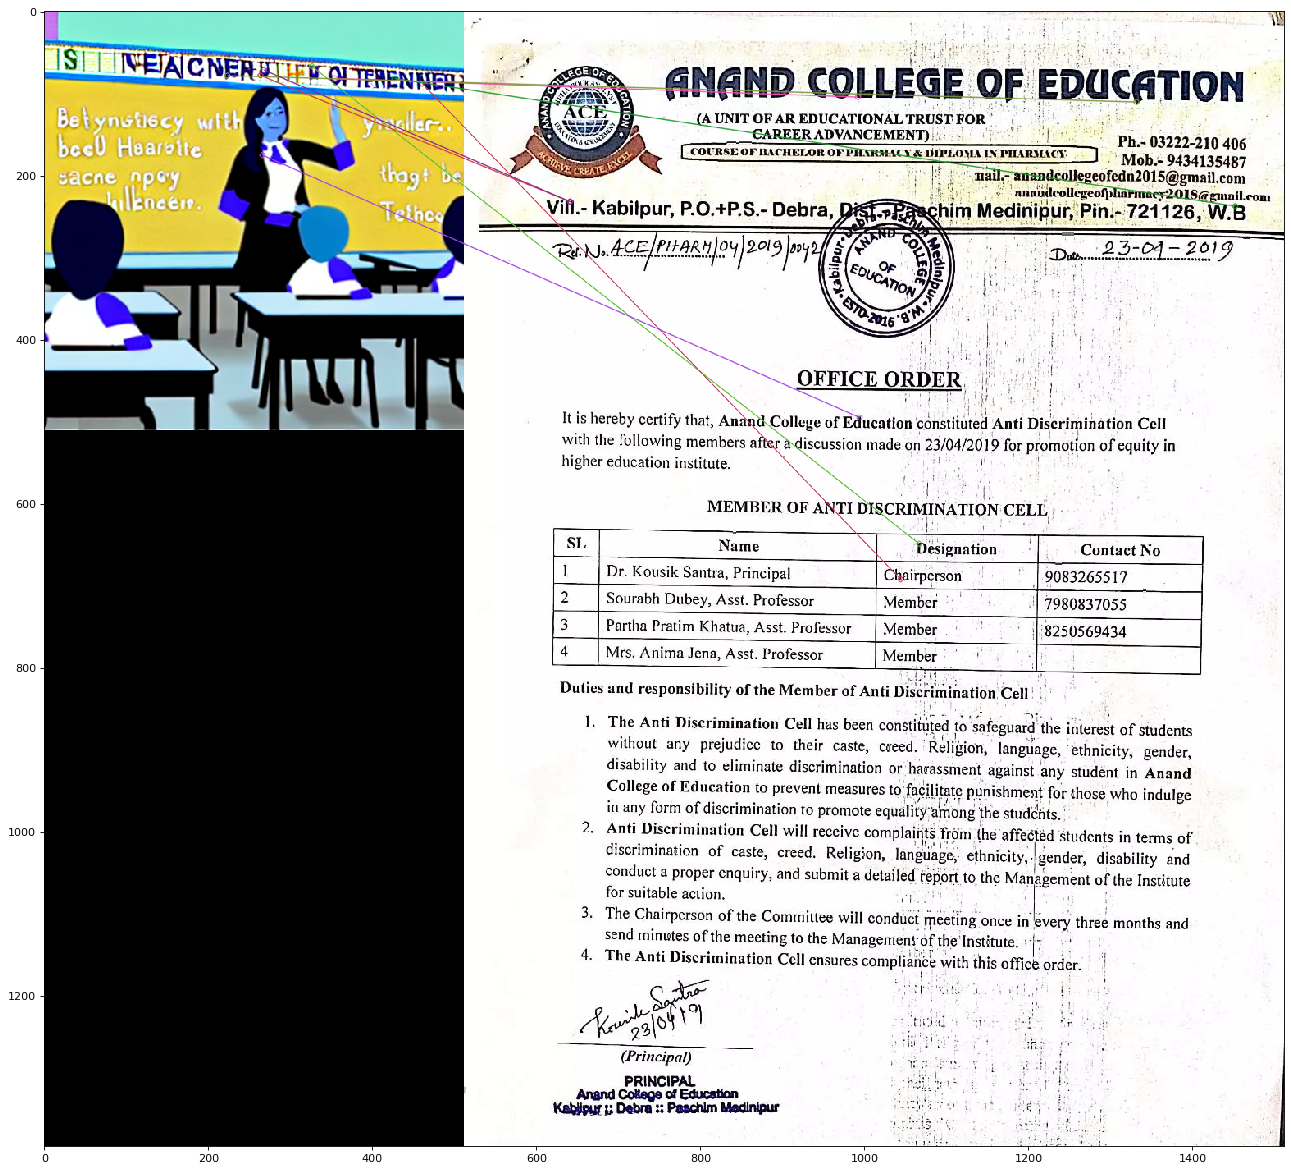

In [13]:
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111)

ax.imshow(best_match_img, interpolation='nearest')
# ax.set_aspect(5)

# plt.imshow(img3, random. rand(8, 90)), 
plt.show()

In [49]:
topic_xml_data = open('dataset22/topics.xml', 'r').read() 

topics_dataframe = pd.read_xml(topic_xml_data)
topics_dataframe

,number,title,description,narrative
0,1,Should teachers get tenure?,A user has heard that some countries do give t...,Highly relevant arguments make a clear stateme...
1,2,Is vaping with e-cigarettes safe?,When considering to switch from smoking to vap...,Highly relevant arguments support or deny the ...
2,3,Should insider trading be allowed?,"Since many marketplaces are liberalized, the u...",Highly relevant arguments argue for or against...
3,4,Should corporal punishment be used in schools?,Discipline in schools is associated with bette...,Highly relevant arguments include ones that ar...
4,5,Should social security be privatized?,"The costs of social security are enormous, and...",Highly relevant arguments take the pro or con ...
5,6,Is a college education worth it?,A lot of educational resources can be found on...,Highly relevant arguments make a statement on ...
6,7,Should felons who have completed their sentenc...,People who committed a serious crime have posi...,Highly relevant arguments consider reasons for...
7,8,Should abortion be legal?,It is an open question at what point human lif...,Highly relevant arguments take a stance for or...
8,9,Should students have to wear school uniforms?,"Promoting equality is a key goal at school, an...",Highly relevant arguments consider the benefit...
9,10,Should any vaccines be required for children?,"Anti-vaccination movements are on the rise, an...",Highly relevant arguments name one or more vac...


In [44]:
topics_dataframe['title'].head(5)

0                       Should teachers get tenure?
1                 Is vaping with e-cigarettes safe?
2                Should insider trading be allowed?
3    Should corporal punishment be used in schools?
4             Should social security be privatized?
Name: title, dtype: object

In [48]:
topics_dataframe.iloc[0]['description']

"A user has heard that some countries do give teachers tenure and others don't. Interested in the reasoning for or against tenure, the user searches for positive and negative arguments. The situation of school teachers vs. university professors is of interest."